### 模型选择、欠拟合、过拟合
通过多项式拟合来交互地探索这些概念

$y=5+1.2x-3.4\dfrac{x^2}{2!}+5.6\dfrac{x^3}{3!}+\varepsilon\,\text{where}\,\varepsilon\,\sim N(0,1^2)$

In [1]:
import math
import numpy as np
import torch
from d2l import torch as d2l

In [2]:
max_degree = 20  # w最大维度
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = [5, 1.2, -3.4, 5.6]  # 前4个值初始化,对应0次,1次,2次,3次

features = np.random.normal(size=(n_train + n_test, 1))  # shape=(200, 1)
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))  # 使用了广播机制
"""
[[x1],[x2],...[x200]]竖过来看 [0,1,2,...,20],每个数分别求0次幂,1次幂,2次幂....19次幂, 结果:
[[x1^0,x1^1,x1^2,...,x1^19] 
 [x2^0,x2^1,x2^2,...,x2^19],
 ......
 [x200^0,x200^1,x200^2,...,x200^19]] 
 ——> shape=(200, 20)
"""

for i in range(1,max_degree):
    poly_features[:, i] /= math.gamma(i)  # `gamma(n)` = (n-1)!, 防止高次幂梯度过大
labels = np.dot(poly_features, true_w)
"""
# 求结果 Dot product of two arrays 
# If a is an N-D array and b is a 1-D array, it is a sum product over the last axis of a and b.
[[x1^0,x1^1,x1^2,...,x1^19] 
 [x2^0,x2^1,x2^2,...,x2^19],
 ......
 [x200^0,x200^1,x200^2,...,x200^19]] · [w1,w2,...w20]
——>[200个结果], eg: 第一个结果为w1·x1^0+w2·x2^1+···+w20·x200^19
"""
labels += np.random.normal(scale=0.1, size=labels.shape)  # 添加噪声
# 全部转float32
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in
                                           [true_w, features, poly_features, labels]]
features[:2], poly_features[:2, :], labels[:2]  # shape分别为(200, 1) (200, 20) (200, )

(tensor([[-1.8122],
         [ 0.5559]]),
 tensor([[ 1.0000e+00, -1.8122e+00,  3.2839e+00, -2.9755e+00,  1.7974e+00,
          -8.1429e-01,  2.9512e-01, -8.9135e-02,  2.3075e-02, -5.2271e-03,
           1.0525e-03, -1.9073e-04,  3.1421e-05, -4.7450e-06,  6.6143e-07,
          -8.5616e-08,  1.0343e-08, -1.1715e-09,  1.2488e-10, -1.2572e-11],
         [ 1.0000e+00,  5.5587e-01,  3.0899e-01,  8.5881e-02,  1.5913e-02,
           2.2114e-03,  2.4585e-04,  2.2777e-05,  1.8087e-06,  1.2568e-07,
           7.7622e-09,  4.3148e-10,  2.1804e-11,  1.0100e-12,  4.3189e-14,
           1.7148e-15,  6.3548e-17,  2.2078e-18,  7.2191e-20,  2.2294e-21]]),
 tensor([-25.1427,   5.1450]))

In [3]:
np.power([[1], [3], [5]], [[0, 1, 2, 3, 4]])

array([[  1,   1,   1,   1,   1],
       [  1,   3,   9,  27,  81],
       [  1,   5,  25, 125, 625]])

In [4]:
# 定义损失
def evaluate_loss(net, data_iter, loss): 
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        y_hat = net(X)
        y = y.reshape(y_hat.shape)
        l = loss(y_hat, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
from src.t06 import train_epoch_ch3
from torch import nn


# 定义训练函数
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置,因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))  # 最简单的单层线性网络
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (
                evaluate_loss(net, test_iter, loss), evaluate_loss(net, train_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

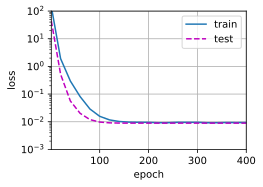

In [6]:
# 三阶多项式函数拟合(正态)  # 模型复杂度与数据集大小匹配
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])
# :n_train前一半,n_train后一半

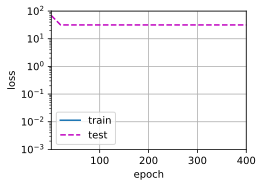

In [7]:
# 线性函数拟合(欠拟合 underfitting)
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train],
      labels[n_train:])  # 只给两个数据(相当于一个线段)
# :n_train前一半,n_train后一半

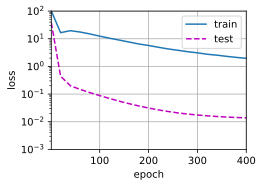

In [8]:
# 高阶多项式函数拟合(过拟合)  # 数据很多(但是只有前4列有用,最后16列weight都是0,把噪声学过来了)
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])